# Cone beam with 2 detectors: longitudinal + transversal

-----------------------------------------------------------------------------------------------------------------------

<u>*The material provided in this notebook can be freely used and modified for educational purposes only. Please cite any content of the notebook as follows:*</u>

- *Panetta D, Camarlinghi N. 3D Image Reconstruction for CT and PET : A Practical Guide with Python. CRC Press; 2020. Available from: https://www.taylorfrancis.com/books/9780429270239*

*For questions, notifications of bugs, or even just for feedback, please contact the authors directly (daniele.panetta@ifc.cnr.it; niccolo.camarlinghi@gmail.com)*

-----------------------------------------------------------------------------------------------------------------------

In [1]:
import sys
import numpy as np
import os
sys.path.append("../") # this to be able to include all the object contained in the modules
from Misc.Utils import Unpickle,ReadImage,DownscaleImage, OutputFileName
from Misc.Preview import Visualize3dImage
import matplotlib.pyplot as plt
# set the default size of all the plots 5x5 inches
plt.rcParams['figure.figsize'] = [5, 5]
from Algorithms.SinogramGenerator_3D_long_transv import SinogramGenerator_3D
from Algorithms.FBP import FBP
from Geometry.ExperimentalSetupCT_3D_long_transv import ExperimentalSetupCT_3D, Mode, DetectorShape
from Algorithms.MLEM import MLEM
from Misc.DataTypes import voxel_dtype


### Create a CT experimental setup

In this case the value of the ```mode``` member of ```my_experimental_setup``` must be set to ```Mode.CONEBEAM```. The chosen detector shape for this example is ```DetectorShape.PLANAR```.
SDD and SAD denote the source-to-detector and source-to-axis distances, respectively. The ```fan_angle_deg```represents the angle of emission of photons. 

The actual size of the detector row is a derived parameter, calculated on top of ```pixels_per_slice_nb``` and ```fan_angle_deg``` as ```2*sdd*tan(fan_angle/2)```. 

The relationship between number of voxels, voxel size and volume size is the same as in the previous examples.

In [27]:
# create CT experimental setup
my_experimental_setup = ExperimentalSetupCT_3D()

my_experimental_setup.mode = Mode.CONEBEAM
my_experimental_setup._detector_number = 2
# detector 
my_experimental_setup.pixels_per_slice_nb=200
my_experimental_setup.detector_slice_nb=200
my_experimental_setup.pixel_size=0.9
my_experimental_setup.slice_pitch_mm=my_experimental_setup.pixel_size

my_experimental_setup.detector_shape=DetectorShape.PLANAR
# fov size in mm 
l = 100
my_experimental_setup.image_matrix_size_mm = np.array([l,l,l])
# voxel size in mm
my_experimental_setup.voxel_size_mm = np.array([1,1,1])
# number of rotation of the gantry
my_experimental_setup.gantry_angles_nb = 8
# range of the rotation
my_experimental_setup.angular_range_deg = 360

#
k = 0
my_experimental_setup.detector_size = my_experimental_setup.pixels_per_slice_nb * my_experimental_setup.slice_pitch_mm#mm
print('det size here: ', my_experimental_setup.detector_size)
sad = l*(l+np.sqrt(2)*k) / (my_experimental_setup.detector_size-np.sqrt(2)*l)
sdd = sad + l/np.sqrt(2) + k
theta = 2 * np.degrees(np.arctan(my_experimental_setup.detector_size / 2 / sdd))

# sources 
my_experimental_setup.sdd_mm=sdd
my_experimental_setup.sad_mm=sad
my_experimental_setup.fan_angle_deg=theta




# compute the geometry
my_experimental_setup.Update()
print(my_experimental_setup.GetInfo())

det size here:  180.0
self.detector_size: 180 mm    #calculated as 2*sdd*tan(fan_angle/2)
Angles:  [  0.  45.  90. 135. 180. 225. 270. 315.]
detector_type: DetectorType.CT
mode: Mode.CONEBEAM
pixels_per_slice_nb: 200
detector_slice_nb: 200
pixel_size: 0.9
slice_pitch_mm: 0.9
detector_shape: DetectorShape.PLANAR
image_matrix_size_mm: [100 100 100]
voxel_size_mm: [1 1 1]
gantry_angles_nb: 8
angular_range_deg: 360
detector_size: 180.0
sdd_mm: 329.92144927777537
sad_mm: 259.2107711591206
fan_angle_deg: 30.517162978738693
number of projections: 360000


You may have noticed that in this example, a voxel size of 4 mm has been chosen along each axis. Indeed, in order to keep the forward and back projection within reasonable time in this single-core, non parallelised educational implementation, we will use a rather coarse reconstruction grid.

### Display the experimental setup

As already done in the previous demos, let's look at the geometry using the ```Draw``` method:

In [ ]:
my_experimental_setup.Draw(use_jupyter=0,camera_pos_mm=(0,-800,400))

### Load the image used to generate cone beam projection data

Let us now load another version of the voxelised 3D phantom. This version is stored in a grid of 100$^3$ voxels (let's assume that each voxel has a side of 1 mm in each direction).

In [14]:
input_file_name = '../Data/cilinder.npz'
input_img = np.load(input_file_name)['matrix']
input_img = np.transpose(input_img, (2, 1, 0))

(100, 100, 100)


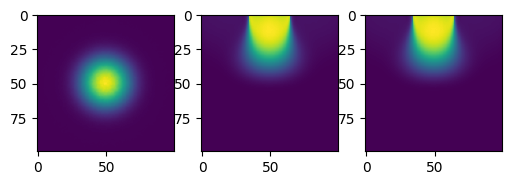

In [28]:
input_file_name = '/home/eleonora/eFLASH_3D_Sim-build/Dose_Map_30mm/spettro_9MeV/doseDistribution.npz'
input_img = np.load(input_file_name)['doseDistr'].astype(np.float64)

fig, ax = plt.subplots(1, 3, figsize=(6,12))
ax[0].imshow(input_img[50,:,:])
ax[1].imshow(input_img[:,50,:])
ax[2].imshow(input_img[:,:,50])

print(input_img.shape)

In [ ]:
input_img[100,:,:]

In [ ]:
input_img = np.fromfile("../Data/SheppLogan3D_100x100x100_16bit_us.raw",dtype=np.uint16).reshape ((100,100,100))
input_img=input_img.astype(voxel_dtype)

fig, ax = plt.subplots(1, 3, figsize=(6,12))
input_img = np.transpose(input_img, (2, 1, 0))
#rotated_img_90 = np.transpose(input_img, (0, 2, 1))[:, :, ::-1
ax[0].imshow(input_img[50,:,:])
#ax[0].invert_yaxis() 
ax[1].imshow(input_img[:,50,:])
#ax[1].invert_yaxis() 
ax[2].imshow(input_img[:,:,50])
#ax[2].invert_yaxis() 
print(input_img.shape)

### Generate and display the projection data
Let us now clarify the meaning of the term *sinogram* in the current geometry. We are actually generating a set of projections of the 3D object, giving rise to a 3D array of line integrals. The shape of the generated array follows the ordering: ```(n_of_radial_bins, n_of gantry_angles, n_of_bins_along_axial_direction)```. That is, the first two dimensions are those used in 2D sinograms as already seen in the previous example. But in cone-beam geometry, we often refer to projection data as *radiographs* of the 3D object, and hence we would like to visualise those data using the ordering ```(n_of_radial_bins, n_of_bins_along_axial_direction, n_of gantry_angles)```. This can be easily done with the ```Draw``` function by just putting ```slice_axis=1``` as the second argument (unlike the previous examples where ```slice_axis=2``` was used).

In [29]:
s=SinogramGenerator_3D(my_experimental_setup)
sino_list=s.GenerateObjectSinogram(input_img,transponse_image=0)

Projection on first detector
shape sino 0:  (200, 1, 200)
Projection on second detector
shape sino 1:  (200, 8, 200)


'\nfig, ax = plt.subplots(1, 3, figsize=(6,12))\nax[0].imshow(sino_list[1]._data[:,2,:])\nax[1].imshow(sino_list[1]._data[:,3,:])\nax[2].imshow(sino_list[1]._data[:,4,:])\n\nfig, ax = plt.subplots(1, 3, figsize=(6,12))\nax[0].imshow(sino_list[1]._data[:,5,:])\nax[1].imshow(sino_list[1]._data[:,6,:])\nax[2].imshow(sino_list[1]._data[:,7,:])\n'

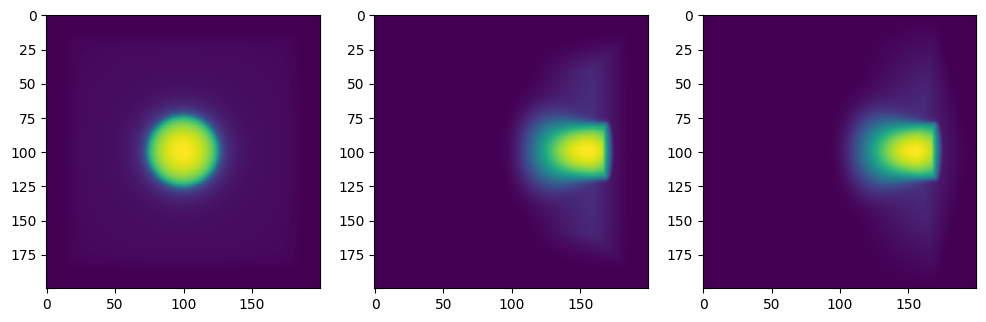

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(12,12))
ax[0].imshow(sino_list[0]._data[:,0,::-1])
ax[1].imshow(sino_list[1]._data[:,0,::-1])
ax[2].imshow(sino_list[1]._data[:,1,::-1])
"""
fig, ax = plt.subplots(1, 3, figsize=(6,12))
ax[0].imshow(sino_list[1]._data[:,2,:])
ax[1].imshow(sino_list[1]._data[:,3,:])
ax[2].imshow(sino_list[1]._data[:,4,:])

fig, ax = plt.subplots(1, 3, figsize=(6,12))
ax[0].imshow(sino_list[1]._data[:,5,:])
ax[1].imshow(sino_list[1]._data[:,6,:])
ax[2].imshow(sino_list[1]._data[:,7,:])
"""


In [31]:
projections_t = np.concatenate(np.concatenate(np.transpose(sino_list[0]._data, axes=(2,1,0)), axis=1))
projections_l = np.concatenate(np.concatenate(np.transpose(sino_list[1]._data, axes=(2,1,0)), axis=1))

projections = np.concatenate((projections_t, projections_l))

print('projections_t.shape, projectionsl.shape, projections.shape:, ', projections_t.shape, projections_l.shape, projections.shape)

projections_t.shape, projectionsl.shape, projections.shape:,  (40000,) (320000,) (360000,)


In [32]:
algorithm="MLEM"
niter=50
initial_value=1

#Info for saving
d1 = my_experimental_setup.sad_mm - my_experimental_setup.image_matrix_size_mm[0] * 0.5

output_file_name = OutputFileName('../Reconstruction/', input_file_name, d1, niter, my_experimental_setup.gantry_angles_nb, my_experimental_setup.fan_angle_deg, k)
print(output_file_name)

../Reconstruction/doseDistribution_d209_i50_p8_t30


In [33]:
# Apre il file in modalità scrittura
with open(output_file_name+'.txt', 'w') as f:
    # Reindirizza l'output di print al file
    print(my_experimental_setup.GetInfo(), file=f)

np.savez(output_file_name + '_proj.npz', projection_t=sino_list[0]._data, projection_l=sino_list[1]._data)

In [34]:
it = eval( algorithm+ "()")
it.SetExperimentalSetup(my_experimental_setup)
it.SetNumberOfIterations(niter)
it.SetProjectionData(projections)
initial_guess=np.full(it.GetNumberOfVoxels(),initial_value, dtype=voxel_dtype) 
it.SetImageGuess(initial_guess)
it.SetOutputBaseName(output_file_name) # uncomment this line to save images to disk
output_img = it.Reconstruct()

Algorithm name MLEM
iteration 1 => time: 61.9 s
iteration 2 => time: 61.7 s
iteration 3 => time: 62.8 s
iteration 4 => time: 63.2 s
iteration 5 => time: 63.6 s
iteration 6 => time: 64.3 s
iteration 7 => time: 64.4 s
iteration 8 => time: 62.4 s
iteration 9 => time: 62.3 s
iteration 10 => time: 61.9 s
iteration 11 => time: 61.5 s
iteration 12 => time: 61.4 s
iteration 13 => time: 61.7 s
iteration 14 => time: 61.9 s
iteration 15 => time: 61.9 s
iteration 16 => time: 62.0 s
iteration 17 => time: 62.1 s
iteration 18 => time: 61.8 s
iteration 19 => time: 62.1 s
iteration 20 => time: 64.9 s
iteration 21 => time: 62.0 s
iteration 22 => time: 62.5 s
iteration 23 => time: 64.2 s
iteration 24 => time: 62.4 s
iteration 25 => time: 64.4 s
iteration 26 => time: 62.5 s
iteration 27 => time: 63.0 s
iteration 28 => time: 62.8 s
iteration 29 => time: 63.4 s
iteration 30 => time: 66.6 s
iteration 31 => time: 65.0 s
iteration 32 => time: 62.7 s
iteration 33 => time: 64.1 s
iteration 34 => time: 64.4 s
ite

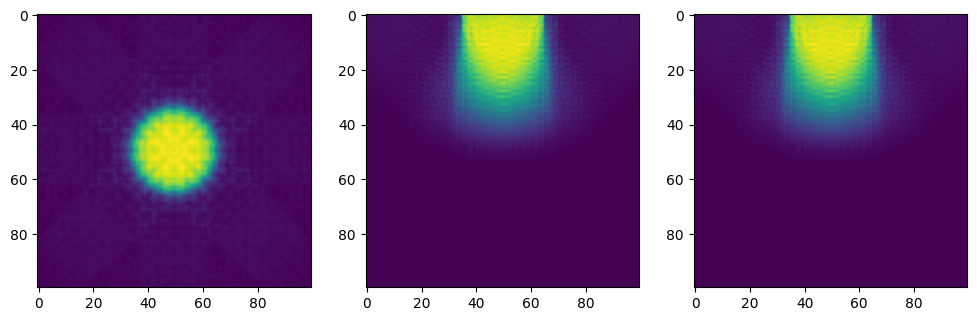

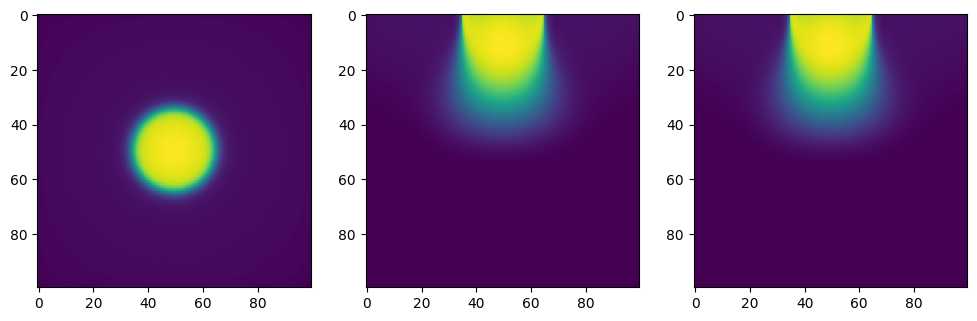

In [36]:
index_x = 12
index_y = 50
index_z = 50

fig, ax = plt.subplots(1, 3, figsize=(12,12))
im=ax[0].imshow(output_img[index_x,:,:])
im=ax[1].imshow(output_img[:,index_y,:] )
im=ax[2].imshow(output_img[:,:,index_z])

fig, ax = plt.subplots(1, 3, figsize=(12,12))
im=ax[0].imshow(input_img[index_x,:,:])
im=ax[1].imshow(input_img[:,index_y,:] )
im=ax[2].imshow(input_img[:,:,index_z])

In [ ]:
from Algorithms.SiddonProjector import SiddonProjector
from Misc.DataTypes import point_dtype

p1 = np.array([(0.0, 0.0, -100.0)],
    dtype=point_dtype)
p2 = np.array([(0.0, 100.0, 100.0)],
    dtype=point_dtype)

s=SiddonProjector(my_experimental_setup.image_matrix_size_mm, my_experimental_setup.voxel_size_mm)
img = s.DrawLine(p1,p2)


In [ ]:
#print(np.argwhere(img!=0))

x, y, z = np.where(img > 0)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_zlim(0, 100)
ax.plot(x, y, z, color='blue', label="Valori > 0")

img[img!=0]
